In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/sp500sub.csv

--2022-01-10 04:33:38--  https://lazyprogrammer.me/course_files/sp500sub.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25473876 (24M) [text/csv]
Saving to: ‘sp500sub.csv’

sp500sub.csv        100%[===================>]  24.29M  14.6MB/s    in 1.7s    

2022-01-10 04:33:40 (14.6 MB/s) - ‘sp500sub.csv’ saved [25473876/25473876]



In [ ]:
df = pd.read_csv('sp500sub.csv', index_col='Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


In [ ]:
sbux = df[df['Name'] == 'SBUX'][['Close']].copy()

In [ ]:
sbux['LogClose'] = np.log(sbux['Close'])

In [ ]:
sbux['DiffLogClose'] = sbux['LogClose'].diff()

In [ ]:
Ntest = 21
train = sbux.iloc[:-Ntest]
test = sbux.iloc[-Ntest:]

In [ ]:
ss = StandardScaler()
train_scaled = ss.fit_transform(train[['DiffLogClose']])
test_scaled = ss.fit_transform(test[['DiffLogClose']])

In [ ]:
# Boolean index

train_idx = sbux.index <= train.index[-1]
test_idx = sbux.index > train.index[-1]

In [ ]:
sbux.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
sbux.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()

In [ ]:
# Make supervised dataset

series = sbux['ScaledLogReturn'].dropna().to_numpy()

T = 10 # number of lags
X = [] # inputs
Y = [] # targets
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2252, 10) Y.shape (2252,)


In [ ]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

### Basic ANN

In [ ]:
# Create input layer with dimensionality T
i = Input(shape = (T,))

# Create 1st hidden layer size of 32 with relu
x = Dense(32, activation = 'relu')(i) 

# Output layer Dense of output size 1. Because the initial model is a 1 step predictor
x = Dense(1)(x) 

# Instantiate model object passing the input and output
model = Model(i, x)

In [ ]:
# Compiling the model object

model.compile(loss = 'mse',
              optimizer = 'adam',
              metrics = 'mae')

In [ ]:
# Call fit function

r = model.fit(Xtrain, Ytrain, epochs = 200,
              validation_data = (Xtest, Ytest)) 

Epoch 1/200
70/70 [==============================] - 1s 4ms/step - loss: 1.2402 - mae: 0.7887 - val_loss: 0.8922 - val_mae: 0.7297
Epoch 2/200
70/70 [==============================] - 0s 2ms/step - loss: 1.0562 - mae: 0.7251 - val_loss: 0.8821 - val_mae: 0.7318
Epoch 3/200
70/70 [==============================] - 0s 2ms/step - loss: 1.0212 - mae: 0.7119 - val_loss: 0.8802 - val_mae: 0.7287
Epoch 4/200
70/70 [==============================] - 0s 2ms/step - loss: 1.0039 - mae: 0.7075 - val_loss: 0.8798 - val_mae: 0.7241
Epoch 5/200
70/70 [==============================] - 0s 2ms/step - loss: 0.9915 - mae: 0.7033 - val_loss: 0.8884 - val_mae: 0.7253
Epoch 6/200
70/70 [==============================] - 0s 2ms/step - loss: 0.9843 - mae: 0.7010 - val_loss: 0.8858 - val_mae: 0.7254
Epoch 7/200
70/70 [==============================] - 0s 2ms/step - loss: 0.9775 - mae: 0.6992 - val_loss: 0.8843 - val_mae: 0.7227
Epoch 8/200
70/70 [==============================] - 0s 2ms/step - loss: 0.9726 - m

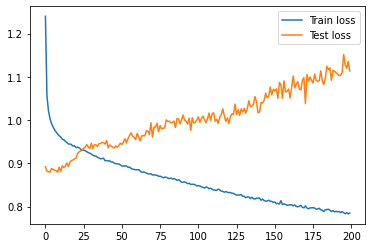

In [ ]:
# Plot train and validation loss

plt.plot(r.history['loss'], label = 'Train loss')
plt.plot(r.history['val_loss'], label = 'Test loss')
plt.legend();

In [ ]:
# First T+1 values are not predictable

train_idx[:T+1] = False 

In [ ]:
# Compute model predictions

Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

# Because the data has been scaled by standard scaler
# we need to invert the scale by calling inverse_transform

Ptrain = ss.inverse_transform(Ptrain).flatten()
Ptest = ss.inverse_transform(Ptest).flatten()

In [ ]:
# Store diff predictions

sbux.loc[train_idx, 'Diff ANN Train Prediction'] = Ptrain
sbux.loc[test_idx, 'Diff ANN Test Prediction'] = Ptest

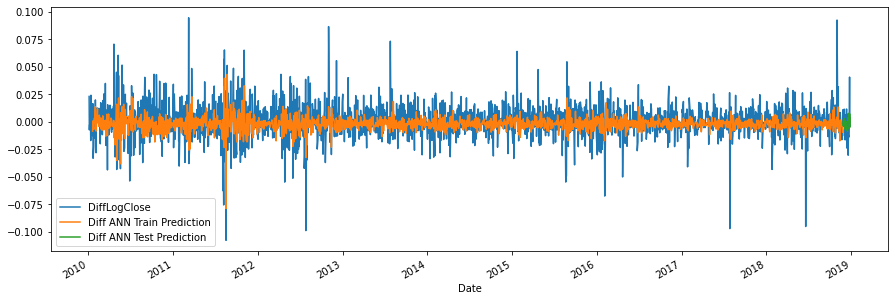

In [ ]:
sbux[['DiffLogClose', 'Diff ANN Train Prediction', 'Diff ANN Test Prediction']].plot(figsize = (15, 5));

In [ ]:
# Need to compute un-differenced predictions

sbux['ShiftLogClose'] = sbux['LogClose'].shift(1)
prev = sbux['ShiftLogClose']

In [ ]:
# Last known train value

last_train = train.iloc[-1]['LogClose']

### 1-step

In [ ]:
# 1-step forecast

sbux.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
sbux.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

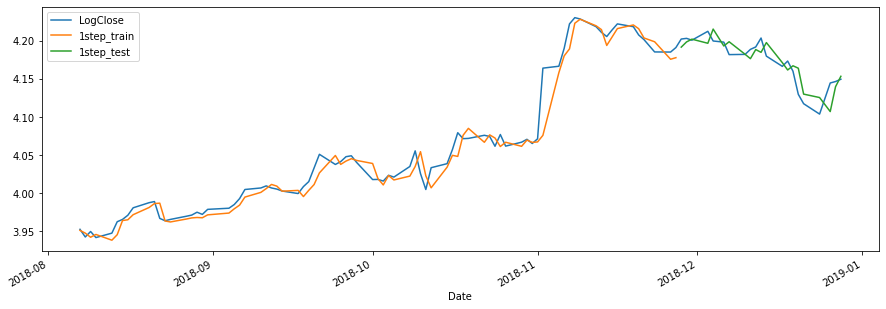

In [ ]:
# Plot 1-step forecast

sbux.iloc[-100:][['LogClose', '1step_train', '1step_test']].plot(figsize = (15, 5));

### Multi-step

In [ ]:
# Multi-step forecast 

multistep_predictions = []

# First test input

last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  # last_x array reshaped because sklearn only accepts 2D input
  p = model(last_x.reshape(1, -1))[0]

  # Update predictions list
  multistep_predictions.append(p)

  # Make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

In [ ]:
# Unscale

# Converting the list into a numpy array
multistep_predictions = np.array(multistep_predictions)

# Reshape to 2D array and flatten it to 1D array
multistep_predictions = ss.inverse_transform(multistep_predictions.reshape(-1, 1)).flatten()

In [ ]:
# Save multi-step forecast to the dataframe

sbux.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

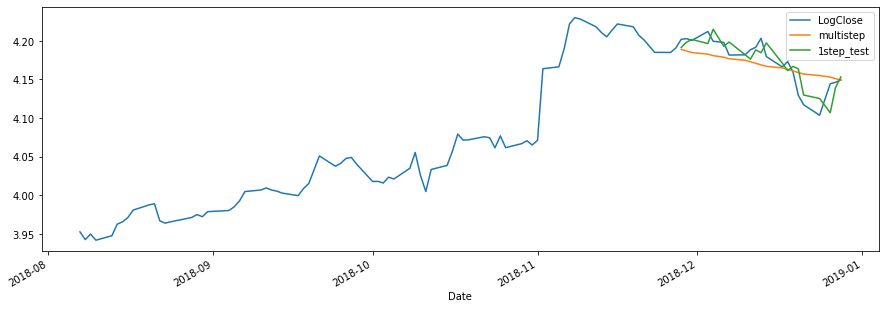

In [ ]:
# Plot 1-step and multistep

sbux.iloc[-100:][['LogClose', 'multistep', '1step_test']].plot(figsize = (15, 5));

### Multi-output

In [ ]:
# Make multi-output supervised dataset

Tx = T      # number of timesteps in the input
Ty = Ntest  # number of timesteps in the output
X = []
Y = []

for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2232, 10) Y.shape (2232, 21)


In [ ]:
# Split into train and test

Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [ ]:
# Basic ANN

# Create input layer with dimensionality T
i = Input(shape = (Tx,))

# Create 1st hidden layer size of 32 with relu
x = Dense(32, activation = 'relu')(i) 

# Output layer Dense of output size 1. Because the initial model is a 1 step predictor
x = Dense(Ty)(x) 

# Instantiate model object passing the input and output
model = Model(i, x)

In [ ]:
# Compiling the model object

model.compile(loss = 'mse',
              optimizer = 'adam',
              metrics = 'mae')

In [ ]:
# Call fit function

r = model.fit(Xtrain_m, Ytrain_m, epochs = 100,
              validation_data = (Xtest_m, Ytest_m))

Epoch 1/100
70/70 [==============================] - 1s 3ms/step - loss: 1.1398 - mae: 0.7574 - val_loss: 0.9852 - val_mae: 0.7536
Epoch 2/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0556 - mae: 0.7231 - val_loss: 0.9896 - val_mae: 0.7537
Epoch 3/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0298 - mae: 0.7122 - val_loss: 0.9933 - val_mae: 0.7547
Epoch 4/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0172 - mae: 0.7070 - val_loss: 1.0016 - val_mae: 0.7551
Epoch 5/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0095 - mae: 0.7039 - val_loss: 0.9971 - val_mae: 0.7528
Epoch 6/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0048 - mae: 0.7018 - val_loss: 0.9985 - val_mae: 0.7548
Epoch 7/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0014 - mae: 0.7005 - val_loss: 1.0006 - val_mae: 0.7549
Epoch 8/100
70/70 [==============================] - 0s 2ms/step - loss: 0.9988 - m

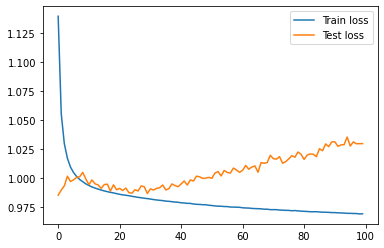

In [ ]:
# Plot train and validation loss

plt.plot(r.history['loss'], label = 'Train loss')
plt.plot(r.history['val_loss'], label = 'Test loss')
plt.legend();

In [ ]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

In [ ]:
Ptrain.shape, Ptest.shape

((2231, 21), (1, 21))

In [ ]:
Ptrain = Ptrain[:, 0]
Ptest = Ptest[0]

In [ ]:
# Unscale
# Reshape to 2D array and flatten it to 1D array
Ptest = ss.inverse_transform(Ptest.reshape(-1, 1)).flatten()

In [ ]:
# Save output to dataframe

sbux.loc[test_idx, 'multioutput'] = last_train + np.cumsum(Ptest)

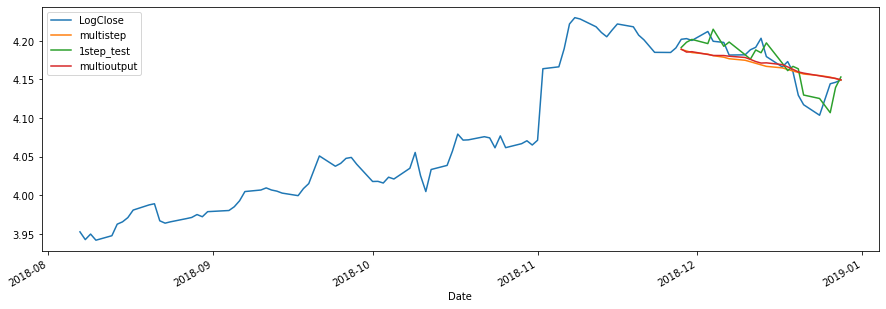

In [ ]:
sbux.iloc[-100:][['LogClose', 'multistep', '1step_test', 'multioutput']].plot(figsize = (15, 5));

In [ ]:
# Use different metric

# MAPE
test_log_pass = sbux.iloc[-Ntest:]['LogClose']

mape1 = mean_absolute_percentage_error(test_log_pass, sbux.loc[test_idx, 'multistep'])
print('Multi-step MAPE:', mape1)

mape2 = mean_absolute_percentage_error(test_log_pass, sbux.loc[test_idx, 'multioutput'])
print('Multi-output MAPE:', mape2)

Multi-step MAPE: 0.0040448481317246696
Multi-output MAPE: 0.003825412187841808


### 1-step Binary Classification

In [ ]:
Ytrain_b = (Ytrain > 0) * 1
Ytest_b = (Ytest > 0) * 1

In [ ]:
# Basic ANN

# Create input layer with dimensionality T
i = Input(shape = (T,))

# Create 1st hidden layer size of 32 with relu
x = Dense(32, activation = 'relu')(i) 

# Output layer Dense of output size 1. Because the initial model is a 1 step predictor
x = Dense(1)(x) 

# Instantiate model object passing the input and output
model = Model(i, x)

In [ ]:
# Compiling the model object
# Use BinaryCrossentropy for binary classification

model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              optimizer = 'adam',
              metrics = ['accuracy'])

In [ ]:
# Call fit function

r = model.fit(Xtrain, Ytrain_b, epochs = 100,
              validation_data = (Xtest, Ytest_b))

Epoch 1/100
70/70 [==============================] - 1s 4ms/step - loss: 0.7154 - accuracy: 0.4948 - val_loss: 0.7165 - val_accuracy: 0.4286
Epoch 2/100
70/70 [==============================] - 0s 2ms/step - loss: 0.7010 - accuracy: 0.5025 - val_loss: 0.7045 - val_accuracy: 0.4286
Epoch 3/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6944 - accuracy: 0.5020 - val_loss: 0.6992 - val_accuracy: 0.4286
Epoch 4/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6908 - accuracy: 0.5034 - val_loss: 0.6925 - val_accuracy: 0.4286
Epoch 5/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6886 - accuracy: 0.5052 - val_loss: 0.6928 - val_accuracy: 0.4286
Epoch 6/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6868 - accuracy: 0.5043 - val_loss: 0.6871 - val_accuracy: 0.4286
Epoch 7/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6858 - accuracy: 0.5056 - val_loss: 0.6866 - val_accuracy: 0.4286
Epoch 8/100
7

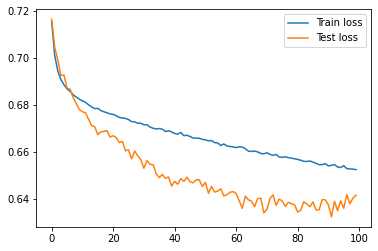

In [ ]:
# Plot train and validation loss

plt.plot(r.history['loss'], label = 'Train loss')
plt.plot(r.history['val_loss'], label = 'Test loss')
plt.legend();

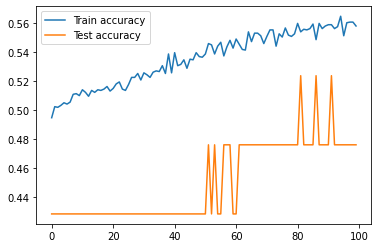

In [ ]:
# Plot train and validation accuracy

plt.plot(r.history['accuracy'], label = 'Train accuracy')
plt.plot(r.history['val_accuracy'], label = 'Test accuracy')
plt.legend();